In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import skeletonize, binary_erosion, binary_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian

THRESHOLD = 100
MAX_PIXEL_VALUE = 255

plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (15, 10)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
# rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

FILENAME='P1-2V-9Hz'


In [13]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, th=THRESHOLD, PRUEBA=False, nombre='BINARY'):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    # esto cierra los globitos, es lo que faltaba antes:
    # for c in np.unique(x):
    #     r = np.where(sk[:, c]!=0)[0]
    #     for p in r:
    #         sk[p, c] = 0
    #     sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

# Pruebas de una captura

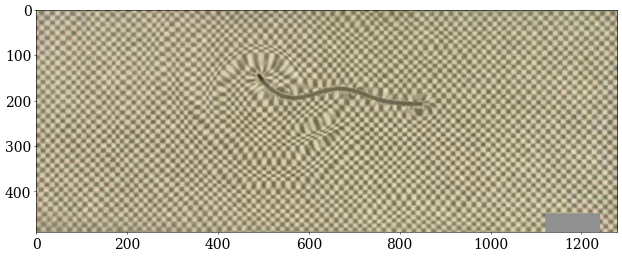

In [14]:
im = skimage.io.imread(f'capture-{FILENAME}-color.tiff')
plt.imshow(im)
im_copy = im.copy()

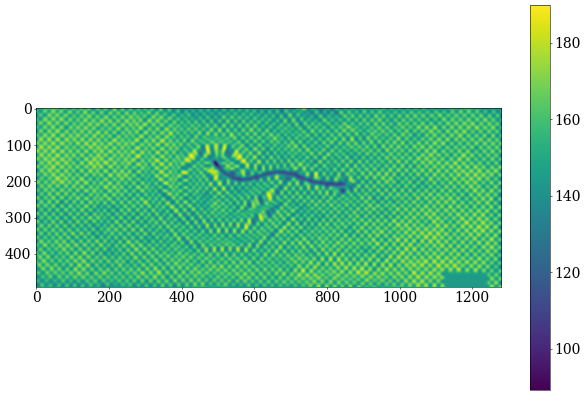

In [15]:
# ref_sobel = sobel(im)
ref_gray = gris(im)

ref_gaussian = gaussian(ref_gray, 4)*255

plt.figure()
plt.imshow(ref_gaussian)
plt.colorbar()


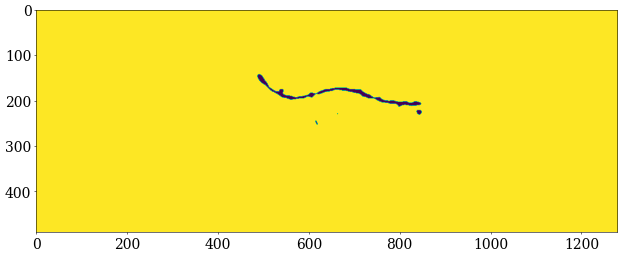

In [16]:
ref_binary = binarize(ref_gaussian, th=120)

plt.figure()
plt.imshow(ref_binary)

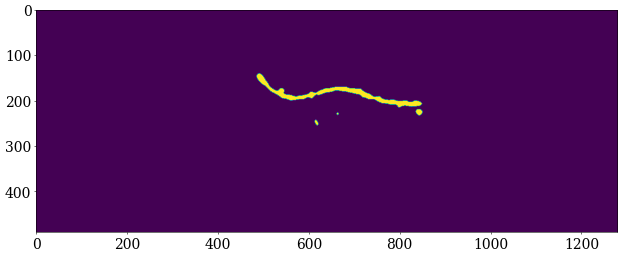

In [17]:
ref_clear = binary_erosion(ref_binary)
ref_clear = binary_erosion(ref_clear)
ref_clear_mask = 1-binary_opening(ref_clear)
ref_clear = ref_clear_mask*255
# ref_clear = cv.bitwise_not(ref_clear)

plt.figure()
plt.imshow(ref_clear)

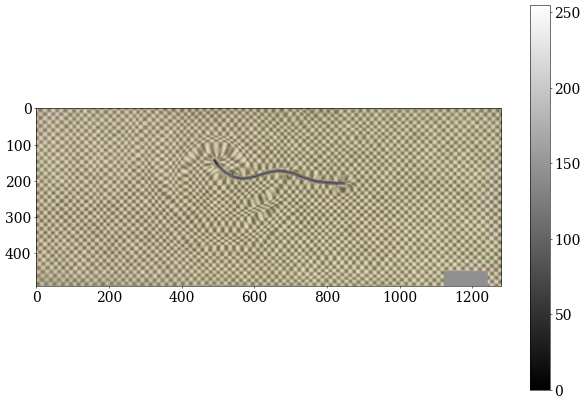

In [20]:
ref_sk = skeletonize(ref_clear)
y, x = np.where(ref_sk!=0)
im_copy[y, x] = [0,0,255]

plt.figure()
plt.imshow(im_copy, cmap='gray')
plt.colorbar()

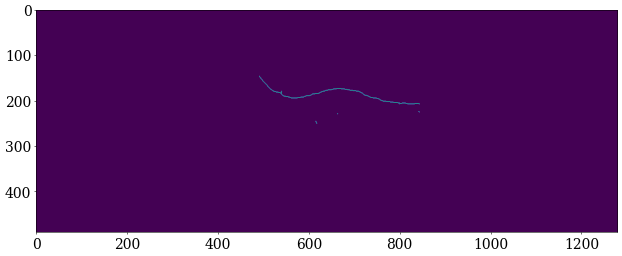

In [36]:
plt.imshow(ref_sk)

# Automatización

In [39]:
def filtrado(frame):
    frame = gris(frame)
    frame = gaussian(frame, 4)*255
    frame = binarize(frame, th=120)
    frame = binary_erosion(frame)
    frame = binary_erosion(frame)
    frame = (1-binary_opening(frame))*255
    return frame

def tracker(vs, mask, lim, SHOW=False):
    # coordenadas de la cola en cada frame      
    pos_sk = []
    pos_tail = []
    pos_head_x = []
    pos_head_y = []
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            frame[mask[0]:mask[1],mask[2]:mask[3]] = 0
            frame = frame[lim[0]:lim[1], :]
            frame = filtrado(frame)
            frame_sk = skeletonize(frame)
            tail = np.where(frame_sk!=0)
            y_tail, x_tail = tail[0],tail[1]
            # para que sólo tome cuando la cola está completa:
            im_izq = cv.bitwise_not(frame_sk[:, 0:1]*1)
            im_der = cv.bitwise_not(frame_sk[:, -2:-1]*1)
            if np.sum(im_der) == 0:
                if np.sum(im_izq) == 0:
                    x_head = np.min(x_tail)
                    filas_tail = np.unique(y_tail)
                    y_head = int(np.mean(filas_tail))
                    
                    pos_head_x.append(x_head)
                    pos_head_y.append(y_head)
                    pos_tail.append(tail)
                    pos_sk.append(frame_sk)
                    
                    if cv.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    break
        else:
            print('Video no leído')
            break
    cv.destroyAllWindows()
    tiempo = [f for f in range(len(pos_sk))]
    print(len(pos_head_y))
    return np.array(tiempo), np.array(pos_sk, dtype='object'), np.array(pos_tail, dtype='object'), np.array(pos_head_x, dtype='object'), np.array(pos_head_y, dtype='object')

In [40]:
vs = cv.VideoCapture(f'videos/FCD/negro/{FILENAME}.mp4')
camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax
lim = [110,600]
t, sk, tails, head_x, head_y = tracker(vs, camo_mask, lim, SHOW=True)

Video no leído
0


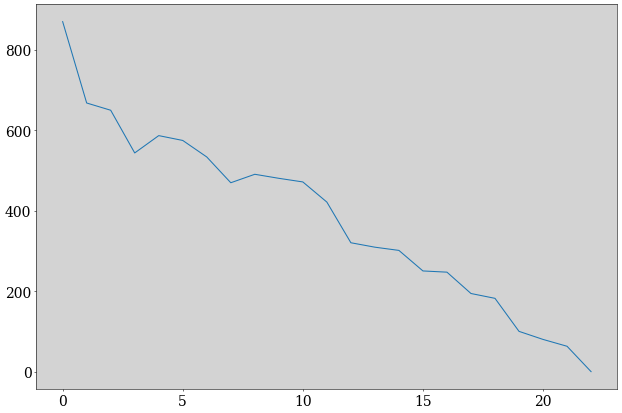

In [19]:
plt.plot(head_x)

# Pruebas código de Pablo

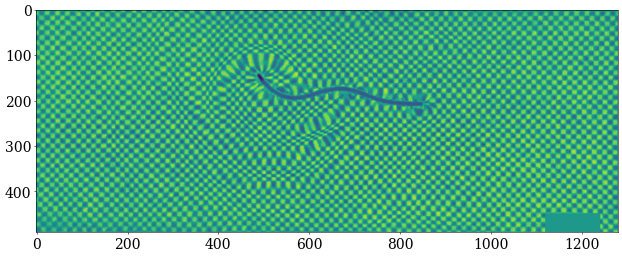

In [293]:
im = skimage.io.imread(f'capture-{FILENAME}.tiff')
# im = skimage.io.imread('P1-capture.jpg')
# im = np.mean(im[100:600,:,:],axis=2)
plt.imshow(im)

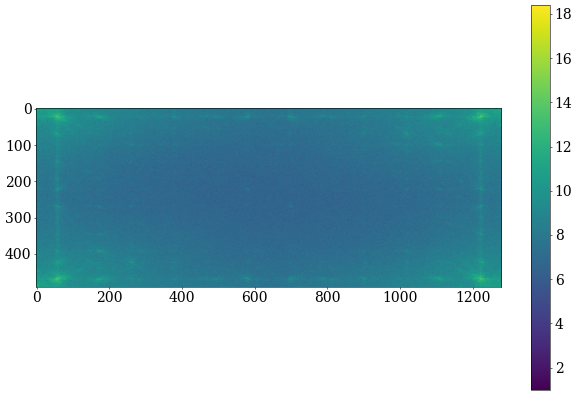

In [294]:
ft = np.fft.fft2(im)
plt.figure()
plt.imshow(np.log(np.abs(ft)))
plt.colorbar()

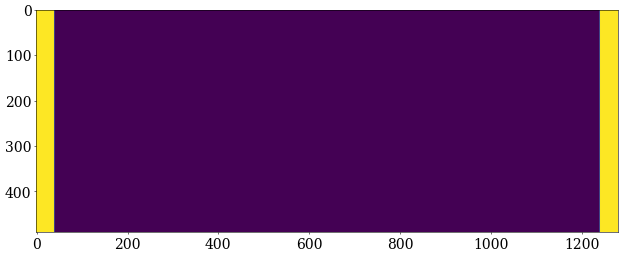

In [322]:
filt = np.zeros_like(im)
# esto es robusto: el filtro puede cambiar ancho entre 10 y 50!
# N = 10
N = 40
filt[:,0:N] = 1
filt[:,-N:] = 1
plt.imshow(filt)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20316\98459067.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  rec = np.fft.ifft2(ftf).astype(float)


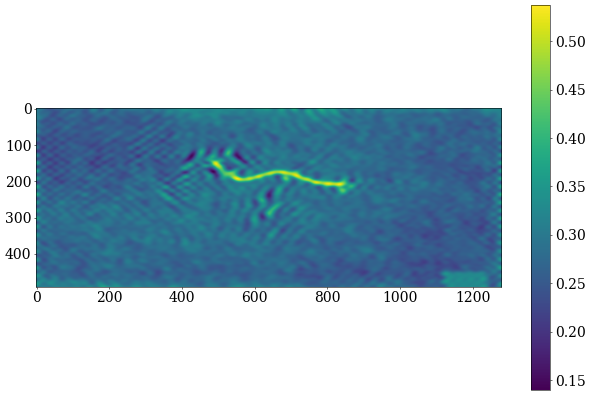

In [378]:
# vamos con la FTP 2D
ftf = ft*filt
# plt.imshow(ftf)
rec = np.fft.ifft2(ftf).astype(float)
rec = rec/np.max(rec)

rec = 1-rec
rec = skimage.morphology.dilation(rec)
# rec = skimage.morphology.dilation(rec)
rec = skimage.filters.gaussian(rec, 4)
# rec = skimage.filters.roberts(rec)
# rec = skimage.morphology.dilation(rec)
# rec = skimage.morphology.dilation(rec)
plt.figure()
plt.imshow(rec)
plt.colorbar()

0.4542823176748049


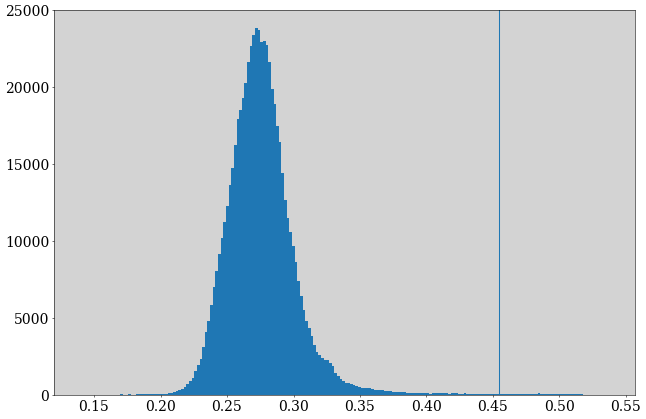

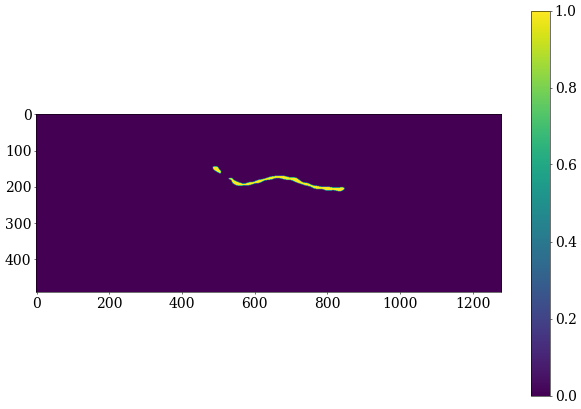

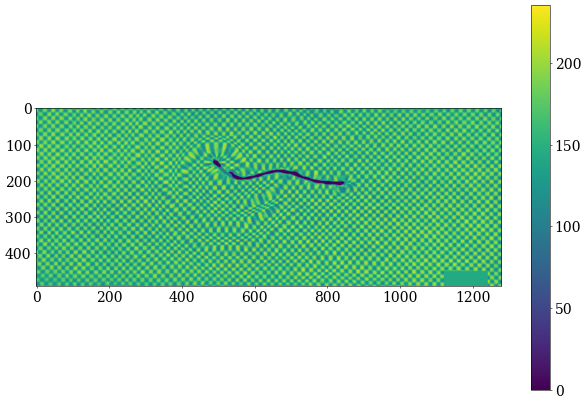

In [383]:
th = threshold_minimum(rec) 
th1 = th - 0.05
# th = 0.5

print(th)
plt.figure()
plt.hist(rec.flatten(), 200)
plt.axvline(th)

binary = rec>th
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.area_closing(binary, 2000)
plt.figure()
# area_
plt.imshow(binary)
plt.colorbar()

plt.figure()
plt.imshow(im*(1-(rec>th)))
plt.colorbar()
